In [1]:
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense , Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
TF_data = pd.read_csv('/content/drive/MyDrive/SMU project/17-23/Data Bucket/TF_DataSaadia_NoEye.csv')
# A copy of the original dataset
TF_data = TF_data[:]

# Drop rows with unknown class labels
TF_data.drop(TF_data[TF_data['1440'] >= 4].index, inplace=True)
print(TF_data['1440'].value_counts())

# Separating data and labels
X= TF_data.drop(columns='1440', axis=1)
Y= TF_data['1440']

# Train and Test data
X_train_, X_test, Y_train_, Y_test= train_test_split(X,Y, test_size=0.2, stratify=Y, random_state=2)
X_train, X_validation, Y_train, Y_validation= train_test_split(X_train_, Y_train_, test_size=0.17, stratify=Y_train_, random_state=1)

X_train= X_train.astype('float32')
X_test= X_test.astype('float32')

print("# of training data =",X_train.shape[0])
print("# of Validation data =",X_validation.shape[0])
print("# of testdata =",X_test.shape[0])

0    52
1    52
2    52
3    52
Name: 1440, dtype: int64
# of training data = 137
# of Validation data = 29
# of testdata = 42


## Task List

Here the following facial expressions will be represented as given below .<br><br>
0  = No Action <br>
1  = Mouth Opened <br>
2  = Pull the lips conner Left<br>
3  = Pull the lips conner Right<br>

In [5]:
task_list=['No Action','Mouth Opened','Pull the lips conner Left','Pull the lips conner Right']

In [6]:
# Normalize the data
sc= StandardScaler()
norm_train_data= pd.DataFrame(sc.fit_transform(X_train), columns= X.columns)
norm_validation_data= pd.DataFrame(sc.fit_transform(X_validation), columns= X.columns)
norm_test_data= pd.DataFrame(sc.fit_transform(X_test), columns= X.columns)

In [7]:
# Training the random forest classifier
from sklearn.ensemble._forest import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Model parameters

# Number of trees in the random forest
n_estimators= np.linspace(100, 3000, int((3000-100)/200)+ 1, dtype=int)

# Number of features to consider at each split
max_features= ['sqrt']

# Maximum number of levels in tree
max_depth= [1, 5, 10, 20, 50, 75, 100, 150, 200]

# Minimum number of samples to split a node
min_samples_split= [2, 5, 10, 15, 20, 30]

# Minimum number of samples needed at each leaf node
min_samples_leaf= [1,2,3,4]

# Method of selecting samples for training each tree
bootstrap= [True, False]

# Criterion
criterion= ['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}


base= RandomForestClassifier()
model= RandomizedSearchCV(estimator = base,
                              param_distributions= random_grid,
                              n_iter= 30, cv= 5,
                              verbose= 2,
                              random_state= 42, n_jobs= 4)
model.fit(X_train_, Y_train_)

model.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'n_estimators': 721,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 100,
 'criterion': 'gini',
 'bootstrap': True}

In [8]:
# Make predictions

Y_pred_random_forest= model.predict(X_test)

print("Test Accuracy for 1st Person :  "+str(round(accuracy_score(Y_test,Y_pred_random_forest)*100 , 2))+' %')

Test Accuracy for 1st Person :  73.81 %


In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn


def give_ConfM(ytest,ypredict):
  labels = unique_labels(Y_test)
  col = [f'Pred{lab}' for lab in labels]
  row = [f'Act{lab}' for lab in labels]

  table = pd.DataFrame(confusion_matrix(ytest,ypredict) , columns=col , index=row)
  return (table)

def get_f1_score(confusion_matrix, i):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for j in range(len(confusion_matrix)):
        if (i == j):
            TP += confusion_matrix[i, j]
            tmp = np.delete(confusion_matrix, i, 0)
            tmp = np.delete(tmp, j, 1)

            TN += np.sum(tmp)
        else:
            if (confusion_matrix[i, j] != 0):

                FN += confusion_matrix[i, j]
            if (confusion_matrix[j, i] != 0):

                FP += confusion_matrix[j, i]

    recall = TP / (FN + TP)
    precision = TP / (TP + FP)
    f1_score = 2 * 1/(1/recall + 1/precision)

    return (f1_score)

Text(0.5, 1.0, 'Confusoin Matrix for Random Forest Classifier')

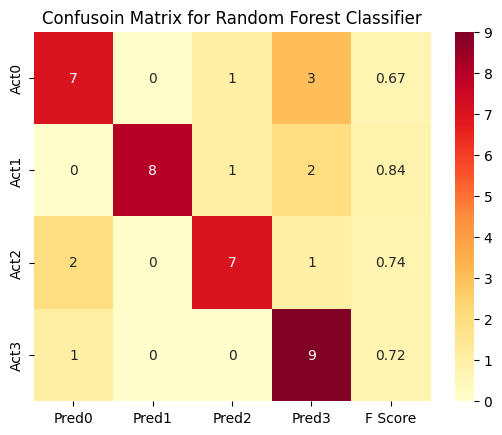

In [10]:
ConFMat= give_ConfM(Y_test,Y_pred_random_forest)
#seaborn.heatmap(ConFMat_X , annot=True, fmt ='d' , cmap='magma')

F_Scores =[]
for i in range(0,4):
  F_Scores.append( get_f1_score(np.array(ConFMat),i))

F_Score_table = np.append(np.array(ConFMat).T ,[F_Scores], axis=0).T

labels = unique_labels(Y_test)
col = [f'Pred{lab}' for lab in labels]+['F Score']
row = [f'Act{lab}' for lab in labels]

table = pd.DataFrame(F_Score_table , columns=col, index=row)

seaborn.heatmap( table, annot=True , cmap='YlOrRd')
plt.title('Confusoin Matrix for Random Forest Classifier')

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid= {'n_estimators': np.linspace(2300, 2500, 5, dtype= int),
#              'max_depth': [5, 10 , 20, 25, 30],
#              'min_samples_split': [9, 10, 11, 12],
#              'min_samples_leaf': [3, 4, 5, 6]}

# rf_grid= RandomForestClassifier(criterion='entropy', bootstrap= False)

# # Grid search model
# grid_rf_search= GridSearchCV(estimator= rf_grid, param_grid= param_grid, cv = 5, n_jobs = 8, verbose = 2)
# grid_rf_search.fit(X_train_, Y_train_)

# best_rf_grid = grid_rf_search.best_estimator_
# grid_rf_search.best_params_


In [ ]:
# # Make predictions

# # Y_pred_random_forest_grid_search= best_rf_grid.predict(X_test)

# print("Test Accuracy for 1st Person :  "+str(round(accuracy_score(Y_test,Y_pred_random_forest_grid_search)*100 , 2))+' %')

In [ ]:
# ConFMat= give_ConfM(Y_test,Y_pred_random_forest_grid_search)
# #seaborn.heatmap(ConFMat_X , annot=True, fmt ='d' , cmap='magma')

# F_Scores =[]
# for i in range(0,5):
#   F_Scores.append( get_f1_score(np.array(ConFMat),i))

# F_Score_table = np.append(np.array(ConFMat).T ,[F_Scores], axis=0).T

# labels = unique_labels(Y_test)
# col = [f'Pred{lab}' for lab in labels]+['F Score']
# row = [f'Act{lab}' for lab in labels]

# table = pd.DataFrame(F_Score_table , columns=col, index=row)

# seaborn.heatmap( table, annot=True , cmap='YlOrRd')
# plt.title('Confusoin Matrix for Random Forest Classifier')